In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# Load the catalog file
cat_file = './data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'
catalog = pd.read_csv(cat_file)

# Display the catalog
print(catalog.head())

# Load the seismic data (CSV format)
data_file = './data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv'
seismic_data = pd.read_csv(data_file)

# Display the seismic data
print(seismic_data.head())


                                  filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  XB.ELYSE.02.BHV.2022-02-03HR08_evid0005     2022-02-03T08:08:27.000000   
1  XB.ELYSE.02.BHV.2022-01-02HR04_evid0006     2022-01-02T04:35:30.000000   

   time_rel(sec)      evid  
0            507  evid0005  
1           2130  evid0006  
   time(%Y-%m-%dT%H:%M:%S.%f)  rel_time(sec)  velocity(c/s)
0  2022-01-02T04:00:00.025000           0.00       0.000000
1  2022-01-02T04:00:00.075000           0.05       0.000503
2  2022-01-02T04:00:00.125000           0.10       0.003635
3  2022-01-02T04:00:00.175000           0.15       0.010198
4  2022-01-02T04:00:00.225000           0.20       0.028214


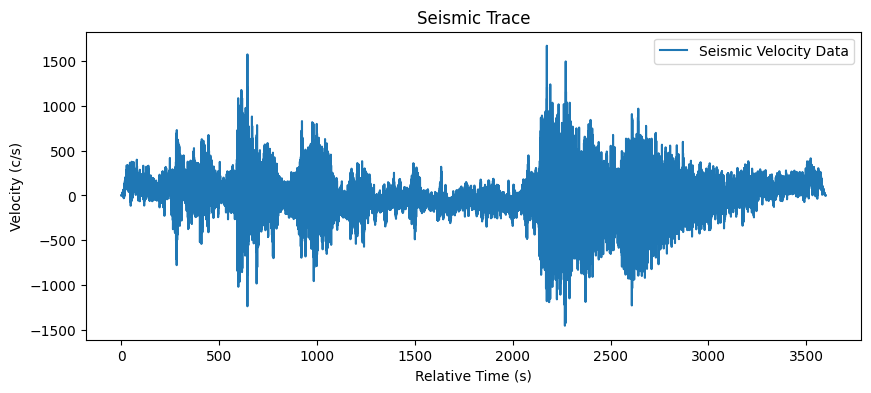

In [2]:
# Convert the absolute time and relative time to datetime and seconds
seismic_data['time_abs'] = pd.to_datetime(seismic_data['time(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')
seismic_data['rel_time'] = seismic_data['rel_time(sec)']

# Extract velocity data
velocity_data = seismic_data['velocity(c/s)'].values
times = seismic_data['rel_time'].values

# Plot the raw data
plt.figure(figsize=(10, 4))
plt.plot(times, velocity_data, label='Seismic Velocity Data')
plt.xlabel('Relative Time (s)')
plt.ylabel('Velocity (c/s)')
plt.title('Seismic Trace')
plt.legend()
plt.show()


In [4]:
from obspy import read
# Select a sample event
row = catalog.iloc[0]
test_filename = row['filename']

# Load the seismic data (MiniSEED format)
data_directory = './data/mars/training/data/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
tr = st[0]  # Get the first (and only) trace

# Display basic information about the trace
print(tr)


XB.ELYSE.02.BHV | 2022-02-03T08:00:00.009000Z - 2022-02-03T08:59:59.959000Z | 20.0 Hz, 72000 samples


In [5]:
# Detrend the data
tr.detrend(type='linear')
tr.detrend(type='demean')

# Apply a bandpass filter
tr.filter('bandpass', freqmin=0.5, freqmax=1.0)

# Get the data and times
data = tr.data
times = tr.times()


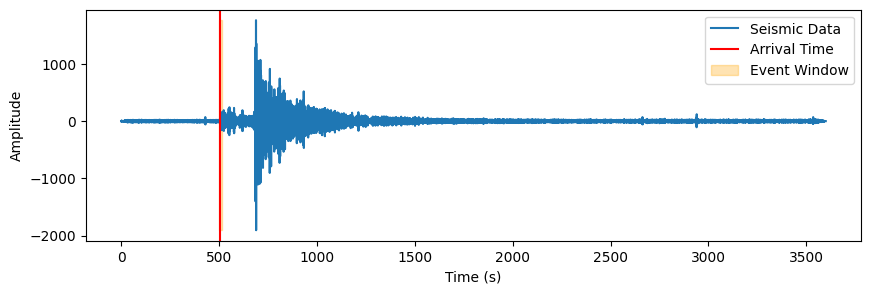

In [6]:
# Get the arrival time relative to the start of the trace
arrival_time_rel = row['time_rel(sec)']

# Define a window around the arrival time to label as 'event'
event_window = 10  # seconds before and after the arrival
event_start = arrival_time_rel - event_window
event_end = arrival_time_rel + event_window

# Create labels
labels = np.zeros(len(times))  # Initialize all labels to 0 (no event)
labels[(times >= event_start) & (times <= event_end)] = 1  # Label event windows as 1

# Plot to verify
plt.figure(figsize=(10, 3))
plt.plot(times, data, label='Seismic Data')
plt.axvline(arrival_time_rel, color='red', label='Arrival Time')
plt.fill_between(times, min(data), max(data), where=(labels == 1), color='orange', alpha=0.3, label='Event Window')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [8]:
from scipy import signal
# Parameters for STFT
fs = tr.stats.sampling_rate  # Sampling frequency
nperseg = 256  # Length of each segment

# Compute STFT
frequencies, times_spec, Sxx = signal.spectrogram(data, fs, nperseg=nperseg)

# Reduce dimensionality by taking the mean across frequency bands
spectral_features = np.mean(Sxx, axis=0)

# Adjust the length to match the labels
min_length = min(len(spectral_features), len(labels))
spectral_features = spectral_features[:min_length]
labels = labels[:min_length]


In [9]:
# Define window size and step size
window_size = int(fs * 1)  # 1-second windows
step_size = int(fs * 0.5)  # 0.5-second steps

# Initialize lists to store features and labels
feature_list = []
label_list = []

for start in range(0, len(data) - window_size, step_size):
    end = start + window_size
    window_data = data[start:end]
    window_label = labels[start:end]
    
    # Extract features
    mean = np.mean(window_data)
    std = np.std(window_data)
    max_val = np.max(window_data)
    min_val = np.min(window_data)
    median = np.median(window_data)
    abs_diff = np.sum(np.abs(np.diff(window_data)))
    
    # Majority label in the window
    label = 1 if np.sum(window_label) > (window_size / 2) else 0
    
    # Append features and label
    feature_list.append([mean, std, max_val, min_val, median, abs_diff])
    label_list.append(label)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# Initialize the classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160

    accuracy                           1.00      2160
   macro avg       1.00      1.00      1.00      2160
weighted avg       1.00      1.00      1.00      2160

Confusion Matrix:
[[2160]]


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


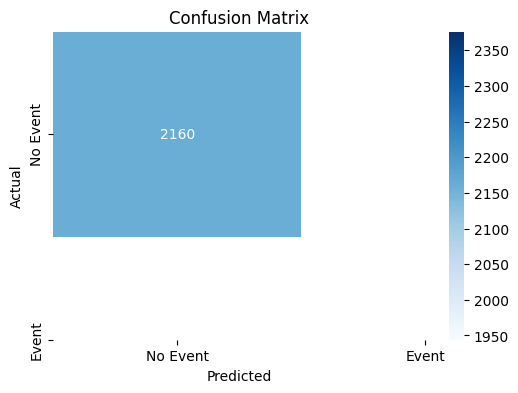

In [14]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['No Event', 'Event'], yticklabels=['No Event', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
